In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('./data/2019_opens_clean.csv')

## Data Cleaning

In [3]:
# drop column "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#### Scores dataframe

In [4]:
# dataframe without benchmarks or height & weight
# consider workout scores before 19.3
scores_cols = ['competitorid', 'gender', 'age', \
               'time_2', \
               'scaled_1', 'scaled_2', \
               'w1_reps_total', \
               'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
               'w3_reps_total', 'w3_hspu_status']
df_scores = df[scores_cols]

# drop rows with missing age values
df_scores = df_scores[df_scores['age'].notna()]
# keep just rows with workouts 19.1-19.3 participated
df_scores = df_scores[df_scores['w1_reps_total'].notna()]
df_scores = df_scores[df_scores['w2_reps_total'].notna()]
df_scores = df_scores[df_scores['w3_reps_total'].notna()]
# drop data from 3rd workout
df_scores.drop(index=1,columns='w3_reps_total',inplace=True)
# drop rows with missing time values
df_scores = df_scores[df_scores['time_2'].notna()]
# set missing tiebreak values to zero
df_scores['w2_tiebreak'].replace(np.NaN,0,inplace=True)
# set categorical gender values to 1/0
df_scores['gender'].replace(['M','F'],[1,0],inplace=True)
# drop rows with unknown hspu status
df_scores = df_scores[df_scores['w3_hspu_status'].notna()]
# numeric values of hspu status as integer
df_scores['w3_hspu_status'] = df_scores['w3_hspu_status'].astype(int)

In [5]:
df_scores.shape

(267408, 14)

In [6]:
df_scores.to_csv('./data/classification_model_input_scores.csv')

#### height&weight dataframe

In [102]:
# dataframe without heights & weights
hw_cols = ['w3_hspu_status', 'height', 'weight', 'gender', 'age']
df_hw = df[hw_cols]

# drop rows with missing values
df_hw = df_hw[df_hw['height'].notna()]
df_hw = df_hw[df_hw['weight'].notna()]
df_hw = df_hw[df_hw['age'].notna()]
df_hw = df_hw[df_hw['w3_hspu_status'].notna()]
# set categorical gender values to 1/0
df_hw['gender'].replace(['M','F'],[1,0],inplace=True)
# numeric values of hspu status as integer
df_hw['w3_hspu_status'] = df_hw['w3_hspu_status'].astype(int)

In [103]:
df_hw.shape

(155298, 5)

In [105]:
df_hw.to_csv('./data/classification_model_input_hw.csv')

#### Scores +hw dataframe

In [152]:
# dataframe without benchmarks
# including heights and weights statistics
# consider workout scores before 19.3
sc_hw_cols = ['competitorid', 'gender', 'age', \
              'time_2', 'scaled_1', 'scaled_2', \
              'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', 'w2_reps_sqcl', \
              'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', 'w3_hspu_status', \
              'height', 'weight']
df_sc_hw = df[sc_hw_cols]

# drop rows with missing age values
df_sc_hw = df_sc_hw[df_sc_hw['age'].notna()]
# keep just rows with workouts 19.1-19.3 participated
df_sc_hw = df_sc_hw[df_sc_hw['w1_reps_total'].notna()]
df_sc_hw = df_sc_hw[df_sc_hw['w2_reps_total'].notna()]
df_sc_hw = df_sc_hw[df_sc_hw['w3_reps_total'].notna()]
# drop data from 3rd workout
df_sc_hw.drop(index=1,columns='w3_reps_total',inplace=True)
# drop rows with missing time values
df_sc_hw = df_sc_hw[df_sc_hw['time_2'].notna()]
# set missing tiebreak values to zero
df_sc_hw['w2_tiebreak'].replace(np.NaN,0,inplace=True)
# set categorical gender values to 1/0
df_sc_hw['gender'].replace(['M','F'],[1,0],inplace=True)
# drop rows with unknown hspu status
df_sc_hw = df_sc_hw[df_sc_hw['w3_hspu_status'].notna()]
# numeric values of hspu status as integer
df_sc_hw['w3_hspu_status'] = df_sc_hw['w3_hspu_status'].astype(int)

# drop rows with missing heights and weights
df_sc_hw = df_sc_hw[df_sc_hw['height'].notna()]
df_sc_hw = df_sc_hw[df_sc_hw['weight'].notna()]

In [153]:
df_sc_hw.shape

(145484, 16)

In [155]:
df_sc_hw.to_csv('./data/classification_model_input_sc_hw.csv')

#### benchmark dataframe

In [225]:
# dataframe with benchmark statistics
bs_cols = [
    'gender', 'w3_hspu_status', \
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
    'bs_filthy50', 'bs_sprint400m', 'bs_run5k']
df_bs = df[bs_cols]

# drop na
df_bs = df_bs.dropna()

# set categorical gender values to 1/0
df_bs['gender'].replace(['M','F'],[1,0],inplace=True)
# numeric values of hspu status as integer
df_bs['w3_hspu_status'] = df_bs['w3_hspu_status'].astype(int)

In [226]:
df_bs.shape

(1947, 14)

In [228]:
df_bs.to_csv('./data/classification_model_input_bs.csv')

#### all data

In [315]:
# dataframe with benchmark statistics
all_cols = [
    'competitorid', 'gender', 'age', \
    'time_2', 'scaled_1', 'scaled_2', \
    'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', 'w2_reps_sqcl', \
    'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', 'w3_hspu_status', \
    'height', 'weight', \
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
    'bs_filthy50', 'bs_sprint400m', 'bs_run5k']
df_all = df[all_cols]

# drop rows with missing age values
df_all = df_all[df_all['age'].notna()]
# keep just rows with workouts 19.1-19.3 participated
df_all = df_all[df_all['w1_reps_total'].notna()]
df_all = df_all[df_all['w2_reps_total'].notna()]
df_all = df_all[df_all['w3_reps_total'].notna()]
# drop data from 3rd workout
df_all.drop(index=1,columns='w3_reps_total',inplace=True)
# drop rows with missing time values
df_all = df_all[df_all['time_2'].notna()]
# set missing tiebreak values to zero
df_all['w2_tiebreak'].replace(np.NaN,0,inplace=True)
# set categorical gender values to 1/0
df_all['gender'].replace(['M','F'],[1,0],inplace=True)
# drop rows with unknown hspu status
df_all = df_all[df_all['w3_hspu_status'].notna()]
# numeric values of hspu status as integer
df_all['w3_hspu_status'] = df_all['w3_hspu_status'].astype(int)

# drop rows with missing heights and weights
df_all = df_all[df_all['height'].notna()]
df_all = df_all[df_all['weight'].notna()]

# drop na
df_all = df_all.dropna()

In [316]:
df_all.shape

(1855, 28)

In [318]:
df_all.to_csv('./data/classification_model_input_all.csv')

## Preprocessing

#### Scores dataframe

In [7]:
# create train and test sets
train_set_sc, test_set_sc = train_test_split(df_scores, test_size=0.3, random_state=42)

# define target and features
y_sc = df_scores['w3_hspu_status']
X_sc = df_scores.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, random_state=42)

In [23]:
# define numerical features for scaling
scale_cols = ['competitorid','age','time_2', \
              'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_sc = scaler.fit_transform(X_train_sc[scale_cols])
X_test_scaled_sc = scaler.transform(X_test_sc[scale_cols])

X_train_preprocessed_sc = np.concatenate([X_train_scaled_sc, X_train_sc.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc = np.concatenate([X_test_scaled_sc, X_test_sc.drop(scale_cols, axis=1)], axis=1)

#### height&weight dataframe

In [106]:
# create train and test sets
train_set_hw, test_set_hw = train_test_split(df_hw, test_size=0.3, random_state=42)

# define target and features
y_hw = df_hw['w3_hspu_status']
X_hw = df_hw.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(X_hw, y_hw, random_state=42)

# define numerical features for scaling
scale_cols = ['age','weight','height']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_hw = scaler.fit_transform(X_train_hw[scale_cols])
X_test_scaled_hw = scaler.transform(X_test_hw[scale_cols])

X_train_preprocessed_hw = np.concatenate([X_train_scaled_hw, X_train_hw.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_hw = np.concatenate([X_test_scaled_hw, X_test_hw.drop(scale_cols, axis=1)], axis=1)

#### Scores +hw dataframe

In [156]:
# create train and test sets
train_set_sc_hw, test_set_sc_hw = train_test_split(df_sc_hw, test_size=0.3, random_state=42)

# define target and features
y_sc_hw = df_sc_hw['w3_hspu_status']
X_sc_hw = df_sc_hw.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train_sc_hw, X_test_sc_hw, y_train_sc_hw, y_test_sc_hw = train_test_split(X_sc_hw, y_sc_hw, random_state=42)

# define numerical features for scaling
scale_cols = ['competitorid','age','time_2', \
              'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
              'weight', 'height']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_sc_hw = scaler.fit_transform(X_train_sc_hw[scale_cols])
X_test_scaled_sc_hw = scaler.transform(X_test_sc_hw[scale_cols])

X_train_preprocessed_sc_hw = np.concatenate([X_train_scaled_sc_hw, X_train_sc_hw.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc_hw = np.concatenate([X_test_scaled_sc_hw, X_test_sc_hw.drop(scale_cols, axis=1)], axis=1)

#### Benchmark dataframe

In [236]:
# create train and test sets
train_set_bs, test_set_bs = train_test_split(df_bs, test_size=0.3, random_state=42, stratify=df_bs[['w3_hspu_status']])

# define target and features
y_bs = df_bs['w3_hspu_status']
X_bs = df_bs.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train_bs, X_test_bs, y_train_bs, y_test_bs = train_test_split(X_bs, y_bs, random_state=42, stratify=df_bs[['w3_hspu_status']])

# define numerical features for scaling
scale_cols = [
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
    'bs_filthy50', 'bs_sprint400m', 'bs_run5k']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_bs = scaler.fit_transform(X_train_bs[scale_cols])
X_test_scaled_bs = scaler.transform(X_test_bs[scale_cols])

X_train_preprocessed_bs = np.concatenate([X_train_scaled_bs, X_train_bs.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_bs = np.concatenate([X_test_scaled_bs, X_test_bs.drop(scale_cols, axis=1)], axis=1)

#### all data

In [319]:
# create train and test sets
train_set_all, test_set_all = train_test_split(df_all, test_size=0.3, random_state=42, stratify=df_all[['w3_hspu_status']])

# define target and features
y_all = df_all['w3_hspu_status']
X_all = df_all.drop(axis=1,columns='w3_hspu_status')

# train test split for model evaluation
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, random_state=42, stratify=df_all[['w3_hspu_status']])

# define numerical features for scaling
scale_cols = [
    'competitorid','age','time_2', \
    'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
    'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
    'weight', 'height', \
    'bs_backsquat', 'bs_cleanandjerk', 'bs_snatch', 'bs_deadlift', \
    'bs_fightgonebad', 'bs_maxpull_ups', 'bs_fran', 'bs_grace', 'bs_helen', \
    'bs_filthy50', 'bs_sprint400m', 'bs_run5k']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled_all = scaler.fit_transform(X_train_all[scale_cols])
X_test_scaled_all = scaler.transform(X_test_all[scale_cols])

X_train_preprocessed_all = np.concatenate([X_train_scaled_all, X_train_all.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_all = np.concatenate([X_test_scaled_all, X_test_all.drop(scale_cols, axis=1)], axis=1)

## Model Selection

### Dummy Accuracy

In [10]:
df_scores['w3_hspu_status'].value_counts()

1    138648
0    128760
Name: w3_hspu_status, dtype: int64

In [11]:
138648/(138648+128760)

0.5184886016873093

In [107]:
df_hw['w3_hspu_status'].value_counts()

1    93604
0    61694
Name: w3_hspu_status, dtype: int64

In [108]:
93604/(93604+61694)

0.602737961853984

In [157]:
df_sc_hw['w3_hspu_status'].value_counts()

1    88088
0    57396
Name: w3_hspu_status, dtype: int64

In [158]:
88088/(88088+57396)

0.6054823898160623

In [230]:
df_bs['w3_hspu_status'].value_counts()

1    1530
0     417
Name: w3_hspu_status, dtype: int64

In [231]:
1530/(1530+417)

0.785824345146379

In [320]:
df_all['w3_hspu_status'].value_counts()

1    1469
0     386
Name: w3_hspu_status, dtype: int64

In [321]:
1469/(1469+386)

0.7919137466307278

##### to beat: Scores - 52% | hw - 60% | sc+hw - 61% | bs - 79% | all - 79%

### Comparison of Algorithms

#### Scores Dataframe

In [24]:
classification_models_sc = []
classification_models_sc.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models_sc.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
#classification_models_sc.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models_sc.append(('Naive Bayes', GaussianNB()))
classification_models_sc.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models_sc.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_sc = []
names_sc = []
for name, model in classification_models:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    result = cross_val_score(model, X_train_preprocessed_sc, y_train_sc, cv=kfold, scoring='accuracy')
    results_sc.append(result)
    names_sc.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 75.23% - SD Accuracy = 0.06%
K Nearest Neighbor: Mean Accuracy = 74.39% - SD Accuracy = 0.15%
Naive Bayes: Mean Accuracy = 71.88% - SD Accuracy = 0.16%
Decision Tree: Mean Accuracy = 69.24% - SD Accuracy = 0.22%
Random Forest: Mean Accuracy = 76.25% - SD Accuracy = 0.07%


In [25]:
# results from unscaled data

    #Logistic Regression: Mean Accuracy = 71.04% - SD Accuracy = 0.27%
    #K Nearest Neighbor: Mean Accuracy = 62.73% - SD Accuracy = 0.19%
    #Naive Bayes: Mean Accuracy = 68.46% - SD Accuracy = 0.14%
    #Decision Tree: Mean Accuracy = 69.22% - SD Accuracy = 0.16%
    #Random Forest: Mean Accuracy = 76.34% - SD Accuracy = 0.11%
    
# results from scaled data

    #Logistic Regression: Mean Accuracy = 75.23% - SD Accuracy = 0.06%
    #K Nearest Neighbor: Mean Accuracy = 74.39% - SD Accuracy = 0.15%
    #Naive Bayes: Mean Accuracy = 71.88% - SD Accuracy = 0.16%
    #Decision Tree: Mean Accuracy = 69.24% - SD Accuracy = 0.22%
    #Random Forest: Mean Accuracy = 76.25% - SD Accuracy = 0.07%

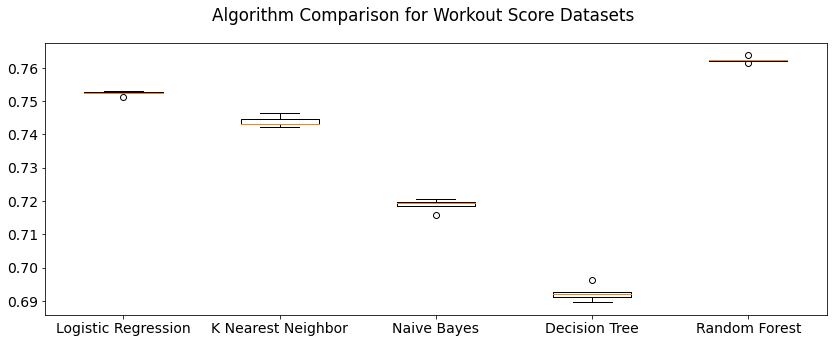

In [26]:
plt.rcParams.update({'figure.figsize': (14, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_sc)
ax.set_xticklabels(names_sc)
plt.show()

#### height&weight dataframe

In [109]:
classification_models_hw = []
classification_models_hw.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models_hw.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
#classification_models_hw.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models_hw.append(('Naive Bayes', GaussianNB()))
classification_models_hw.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models_hw.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_hw = []
names_hw = []
for name, model in classification_models_hw:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    result = cross_val_score(model, X_train_preprocessed_hw, y_train_hw, cv=kfold, scoring='accuracy')
    results_hw.append(result)
    names_hw.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 66.91% - SD Accuracy = 0.25%
K Nearest Neighbor: Mean Accuracy = 64.43% - SD Accuracy = 0.18%
Naive Bayes: Mean Accuracy = 63.76% - SD Accuracy = 0.20%
Decision Tree: Mean Accuracy = 61.04% - SD Accuracy = 0.35%
Random Forest: Mean Accuracy = 63.76% - SD Accuracy = 0.24%


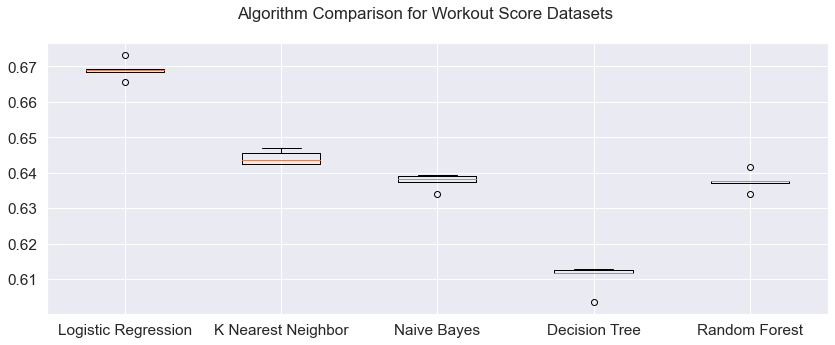

In [110]:
plt.rcParams.update({'figure.figsize': (14, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_hw)
ax.set_xticklabels(names_hw)
plt.show()

#### Scores +hw dataframe

In [159]:
classification_models_sc_hw = []
classification_models_sc_hw.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models_sc_hw.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
#classification_models_sc_hw.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models_sc_hw.append(('Naive Bayes', GaussianNB()))
classification_models_sc_hw.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models_sc_hw.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_sc_hw = []
names_sc_hw = []
for name, model in classification_models_sc_hw:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    result = cross_val_score(model, X_train_preprocessed_sc_hw, y_train_sc_hw, cv=kfold, scoring='accuracy')
    results_sc_hw.append(result)
    names_sc_hw.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 78.11% - SD Accuracy = 0.13%
K Nearest Neighbor: Mean Accuracy = 77.15% - SD Accuracy = 0.18%
Naive Bayes: Mean Accuracy = 73.52% - SD Accuracy = 0.24%
Decision Tree: Mean Accuracy = 72.59% - SD Accuracy = 0.29%
Random Forest: Mean Accuracy = 79.55% - SD Accuracy = 0.09%


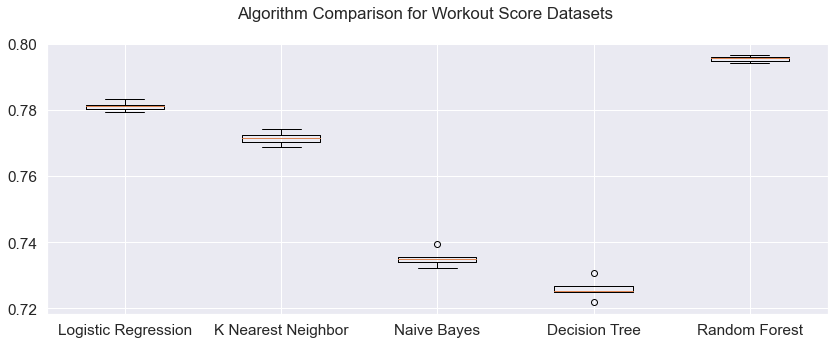

In [160]:
plt.rcParams.update({'figure.figsize': (14, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_sc_hw)
ax.set_xticklabels(names_sc_hw)
plt.show()

#### benchmark dataframe

In [237]:
classification_models_bs = []
classification_models_bs.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models_bs.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
#classification_models_bs.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models_bs.append(('Naive Bayes', GaussianNB()))
classification_models_bs.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models_bs.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_bs = []
names_bs = []
for name, model in classification_models_bs:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    result = cross_val_score(model, X_train_preprocessed_bs, y_train_bs, cv=kfold, scoring='accuracy')
    results_bs.append(result)
    names_bs.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 84.25% - SD Accuracy = 3.20%
K Nearest Neighbor: Mean Accuracy = 83.08% - SD Accuracy = 2.08%
Naive Bayes: Mean Accuracy = 80.75% - SD Accuracy = 2.15%
Decision Tree: Mean Accuracy = 77.47% - SD Accuracy = 2.67%
Random Forest: Mean Accuracy = 84.38% - SD Accuracy = 2.79%


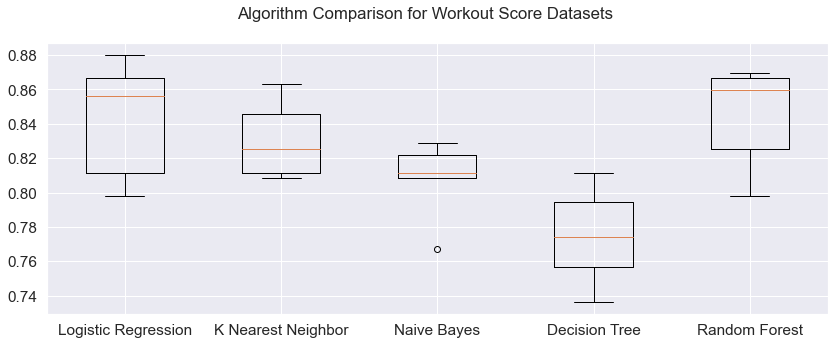

In [238]:
plt.rcParams.update({'figure.figsize': (14, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_bs)
ax.set_xticklabels(names_bs)
plt.show()

#### all data

In [323]:
classification_models_all = []
classification_models_all.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models_all.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
classification_models_all.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models_all.append(('Naive Bayes', GaussianNB()))
classification_models_all.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models_all.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))

results_all = []
names_all = []
for name, model in classification_models_all:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    result = cross_val_score(model, X_train_preprocessed_all, y_train_all, cv=kfold, scoring='accuracy')
    results_all.append(result)
    names_all.append(name)
    print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, result.mean()*100, result.std()*100))

Logistic Regression: Mean Accuracy = 85.48% - SD Accuracy = 1.03%
K Nearest Neighbor: Mean Accuracy = 84.18% - SD Accuracy = 1.37%
Kernel SVM: Mean Accuracy = 85.91% - SD Accuracy = 1.79%
Naive Bayes: Mean Accuracy = 80.16% - SD Accuracy = 1.88%
Decision Tree: Mean Accuracy = 81.09% - SD Accuracy = 1.39%
Random Forest: Mean Accuracy = 85.48% - SD Accuracy = 1.08%


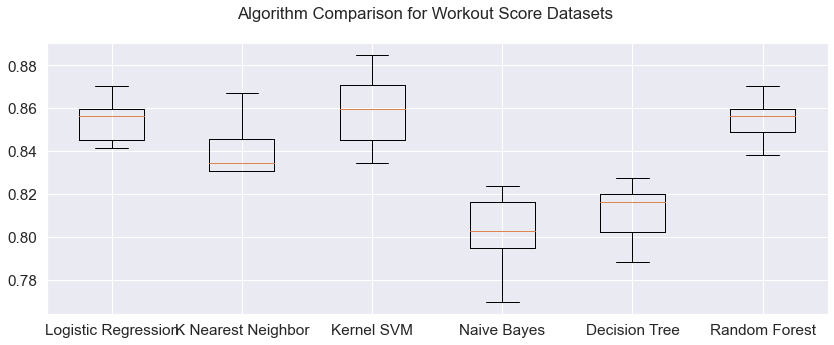

In [324]:
plt.rcParams.update({'figure.figsize': (14, 5)})
plt.rcParams.update({'font.size': 14})

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Workout Score Datasets')
ax = fig.add_subplot(111)
plt.boxplot(results_all)
ax.set_xticklabels(names_all)
plt.show()

## Fine Tune Model

#### Scores dataframe

In [344]:
model_sc = RandomForestClassifier(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_sc.fit(X_train_preprocessed_sc, y_train_sc)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [345]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_sc.score(X_train_preprocessed_sc, y_train_sc), 
                                                                                              model_sc.oob_score_,
                                                                                              model_sc.score(X_test_preprocessed_sc, y_test_sc)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.7597 
Validation Accuracy: 0.7607


In [346]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [10],
              "max_features" : [10],
              "max_leaf_nodes" : [500],
              "max_samples" : [None],
              #"min_impurity_decrease" : [0.001],
              #"min_impurity_split" : [10],
              #"min_samples_leaf" : [1],
              #"min_samples_split" : [2],
              #"min_weight_fraction_leaf" : [0.00000000001],
              "n_estimators" : [100]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_sc, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)

In [347]:
gs.fit(X_train_preprocessed_sc, y_train_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': [10],
                         'max_leaf_nodes': [500], 'max_samples': [None],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=5)

In [72]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=10, max_features=10, max_leaf_nodes=500,
                       min_impurity_decrease=0.001, n_jobs=-1, oob_score=True,
                       random_state=42)

 The best score across ALL searched params:
 0.7659357016429389

 The best parameters across ALL searched params:
 {'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': 500, 'max_samples': None, 'min_impurity_decrease': 0.001, 'n_estimators': 100}


In [ ]:
# 0.7755439973628426

In [348]:
model_sc = RandomForestClassifier(
    max_depth = 10,
    max_features = 10,
    max_leaf_nodes = 500,
    max_samples = None,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_sc.fit(X_train_preprocessed_sc, y_train_sc)

RandomForestClassifier(max_depth=10, max_features=10, max_leaf_nodes=500,
                       n_jobs=-1, oob_score=True, random_state=42)

In [349]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_sc.score(X_train_preprocessed_sc, y_train_sc), 
                                                                                              model_sc.oob_score_,
                                                                                              model_sc.score(X_test_preprocessed_sc, y_test_sc)))

Training Accuracy: 0.7841 
OOB Accuracy: 0.7752 
Validation Accuracy: 0.7738


#### height&weight dataframe

In [113]:
model_hw = LogisticRegression(random_state = 42)
model_hw.fit(X_train_preprocessed_hw, y_train_hw)

LogisticRegression(random_state=42)

In [115]:
print('Training Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_hw.score(X_train_preprocessed_hw, y_train_hw),
                                                                       model_hw.score(X_test_preprocessed_hw, y_test_hw)))

Training Accuracy: 0.6692 
Validation Accuracy: 0.6714


In [146]:
#LogisticRegression().get_params()

In [144]:
# Defining parameter grid (as dictionary)
param_grid = {
    'C' : [5.0],
    #'multi_class' : ['auto'],
    'penalty' : ['l2'],
    #'solver' : ['lbfgs'],
    'tol' : [0.0001]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_hw, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)

gs.fit(X_train_preprocessed_hw, y_train_hw)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [5.0], 'penalty': ['l2'], 'tol': [0.0001]},
             scoring='accuracy', verbose=5)

In [145]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=5.0, random_state=42)

 The best score across ALL searched params:
 0.6691250567855411

 The best parameters across ALL searched params:
 {'C': 5.0, 'penalty': 'l2', 'tol': 0.0001}


In [143]:
# 0.6691250567855411

In [147]:
model_hw = LogisticRegression(random_state = 42)
model_hw.fit(X_train_preprocessed_hw, y_train_hw)

LogisticRegression(random_state=42)

In [148]:
print('Training Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_hw.score(X_train_preprocessed_hw, y_train_hw),
                                                                       model_hw.score(X_test_preprocessed_hw, y_test_hw)))

Training Accuracy: 0.6692 
Validation Accuracy: 0.6714


#### Scores +hw dataframe

In [161]:
model_sc_hw = RandomForestClassifier(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_sc_hw.fit(X_train_preprocessed_sc_hw, y_train_sc_hw)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [162]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_sc_hw.score(X_train_preprocessed_sc_hw, y_train_sc_hw), 
                                                                                              model_sc_hw.oob_score_,
                                                                                              model_sc_hw.score(X_test_preprocessed_sc_hw, y_test_sc_hw)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.7916 
Validation Accuracy: 0.7978


In [216]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [15],
              "max_features" : [3],
              #"max_leaf_nodes" : [800],
              #"max_samples" : [None],
              #"min_impurity_decrease" : [0.00001],
              #"min_impurity_split" : [],
              #"min_samples_leaf" : [1],
              "min_samples_split" : [50],
              #"min_weight_fraction_leaf" : [0.00000000001],
              "n_estimators" : [100]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_sc_hw, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)
gs.fit(X_train_preprocessed_sc_hw, y_train_sc_hw)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15], 'max_features': [3],
                         'min_samples_split': [40, 50, 60],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=5)

In [217]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=15, max_features=3, min_samples_split=50,
                       n_jobs=-1, oob_score=True, random_state=42)

 The best score across ALL searched params:
 0.8010135980713142

 The best parameters across ALL searched params:
 {'max_depth': 15, 'max_features': 3, 'min_samples_split': 50, 'n_estimators': 100}


In [177]:
# 0.8010135980713142

In [218]:
model_sc_hw = RandomForestClassifier(
    max_depth = 15,
    max_features = 3,
    min_samples_split = 50,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_sc_hw.fit(X_train_preprocessed_sc_hw, y_train_sc_hw)

RandomForestClassifier(max_depth=15, max_features=3, min_samples_split=50,
                       n_jobs=-1, oob_score=True, random_state=42)

In [219]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_sc_hw.score(X_train_preprocessed_sc_hw, y_train_sc_hw), 
                                                                                              model_sc_hw.oob_score_,
                                                                                              model_sc_hw.score(X_test_preprocessed_sc_hw, y_test_sc_hw)))

Training Accuracy: 0.8344 
OOB Accuracy: 0.8008 
Validation Accuracy: 0.8020


#### Benchmark dataframe

In [239]:
model_bs = RandomForestClassifier(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_bs.fit(X_train_preprocessed_bs, y_train_bs)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [241]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_bs.score(X_train_preprocessed_bs, y_train_bs), 
                                                                                              model_bs.oob_score_,
                                                                                              model_bs.score(X_test_preprocessed_bs, y_test_bs)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.8404 
Validation Accuracy: 0.8234


In [305]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [16,17,18,19,20],
              "max_features" : [1,2,3,4],
              #"max_leaf_nodes" : [155],
              #"max_samples" : [None],
              #"min_impurity_decrease" : [1e-5],
              #"min_impurity_split" : [],
              #"min_samples_leaf" : [1],
              #"min_samples_split" : [50],
              #"min_weight_fraction_leaf" : [0.00000000001],
              "n_estimators" : [100]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_bs, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)
gs.fit(X_train_preprocessed_bs, y_train_bs)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [16, 17, 18, 19, 20],
                         'max_features': [1, 2, 3, 4], 'n_estimators': [100]},
             scoring='accuracy', verbose=5)

In [306]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=18, max_features=2, n_jobs=-1, oob_score=True,
                       random_state=42)

 The best score across ALL searched params:
 0.8589041095890411

 The best parameters across ALL searched params:
 {'max_depth': 18, 'max_features': 2, 'n_estimators': 100}


In [307]:
# 0.8589041095890411

In [308]:
model_bs = RandomForestClassifier(
    max_depth = 18,
    max_features = 2,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_bs.fit(X_train_preprocessed_bs, y_train_bs)

RandomForestClassifier(max_depth=18, max_features=2, n_jobs=-1, oob_score=True,
                       random_state=42)

In [309]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_bs.score(X_train_preprocessed_bs, y_train_bs), 
                                                                                              model_bs.oob_score_,
                                                                                              model_bs.score(X_test_preprocessed_bs, y_test_bs)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.8466 
Validation Accuracy: 0.8296


#### all data

In [325]:
model_all = RandomForestClassifier(
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_all.fit(X_train_preprocessed_all, y_train_all)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [326]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_all.score(X_train_preprocessed_all, y_train_all), 
                                                                                              model_all.oob_score_,
                                                                                              model_all.score(X_test_preprocessed_all, y_test_all)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.8584 
Validation Accuracy: 0.8513


In [337]:
# Defining parameter grid (as dictionary)
param_grid = {"max_depth" : [18],
              "max_features" : [6],
              #"max_leaf_nodes" : [100],
              #"max_samples" : [None],
              #"min_impurity_decrease" : [1e-5],
              #"min_impurity_split" : [],
              #"min_samples_leaf" : [1],
              #"min_samples_split" : [50],
              #"min_weight_fraction_leaf" : [0.00000000001],
              "n_estimators" : [100]
             }
scoring = 'accuracy'
# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(model_all, param_grid, cv=5, verbose=5, n_jobs=-1, scoring=scoring)
gs.fit(X_train_preprocessed_all, y_train_all)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [18], 'max_features': [6],
                         'max_leaf_nodes': [90, 100, 110],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=5)

In [338]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs.best_estimator_)
print("\n The best score across ALL searched params:\n",gs.best_score_)
print("\n The best parameters across ALL searched params:\n",gs.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=18, max_features=6, max_leaf_nodes=100,
                       n_jobs=-1, oob_score=True, random_state=42)

 The best score across ALL searched params:
 0.8540393491658286

 The best parameters across ALL searched params:
 {'max_depth': 18, 'max_features': 6, 'max_leaf_nodes': 100, 'n_estimators': 100}


In [ ]:
# 0.8569299399190324

In [339]:
model_all = RandomForestClassifier(
    max_depth = 18,
    max_features = 6,
    n_estimators = 100,
    n_jobs = -1,
    oob_score = True,
    bootstrap = True,
    random_state = 42
)
model_all.fit(X_train_preprocessed_all, y_train_all)

RandomForestClassifier(max_depth=18, max_features=6, n_jobs=-1, oob_score=True,
                       random_state=42)

In [340]:
print('Training Accuracy: {:.4f} \nOOB Accuracy: {:.4f} \nValidation Accuracy: {:.4f}'.format(model_all.score(X_train_preprocessed_all, y_train_all), 
                                                                                              model_all.oob_score_,
                                                                                              model_all.score(X_test_preprocessed_all, y_test_all)))

Training Accuracy: 1.0000 
OOB Accuracy: 0.8505 
Validation Accuracy: 0.8534


## Visualization

#### Scores dataframe

In [350]:
y_pred_sc = model_sc.predict(X_test_preprocessed_sc)

In [351]:
cf_sc = confusion_matrix(y_test_sc, y_pred_sc)
cf_sc

array([[26349,  5832],
       [ 9291, 25380]])

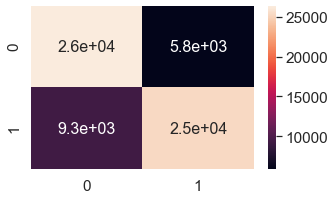

In [352]:
plt.rcParams.update({'figure.figsize': (5, 3)})
plt.rcParams.update({'font.size': 14})

sns.set(font_scale=1.4) # for label size
sns.heatmap(cf_sc, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### height&weight dataframe

In [149]:
y_pred_hw = model_hw.predict(X_test_preprocessed_hw)
cf_hw = confusion_matrix(y_test_hw, y_pred_hw)
cf_hw

array([[ 6719,  8783],
       [ 3973, 19350]])

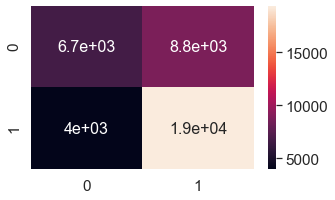

In [150]:
plt.rcParams.update({'figure.figsize': (5, 3)})
plt.rcParams.update({'font.size': 14})

sns.set(font_scale=1.4) # for label size
sns.heatmap(cf_hw, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### Scores +hw dataframe

In [220]:
y_pred_sc_hw = model_sc_hw.predict(X_test_preprocessed_sc_hw)
cf_sc_hw = confusion_matrix(y_test_sc_hw, y_pred_sc_hw)
cf_sc_hw

array([[10770,  3658],
       [ 3543, 18400]])

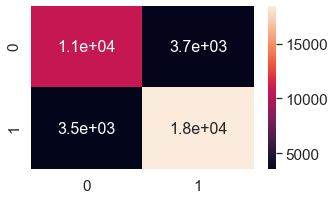

In [221]:
plt.rcParams.update({'figure.figsize': (5, 3)})
plt.rcParams.update({'font.size': 14})

sns.set(font_scale=1.4) # for label size
sns.heatmap(cf_sc_hw, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### benchmark dataframe

In [310]:
y_pred_bs = model_bs.predict(X_test_preprocessed_bs)
cf_bs = confusion_matrix(y_test_bs, y_pred_bs)
cf_bs

array([[ 48,  56],
       [ 27, 356]])

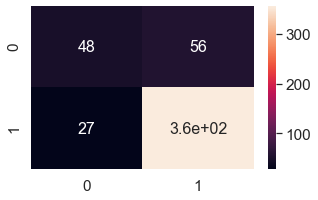

In [311]:
plt.rcParams.update({'figure.figsize': (5, 3)})
plt.rcParams.update({'font.size': 14})

sns.set(font_scale=1.4) # for label size
sns.heatmap(cf_bs, annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### all data

In [341]:
y_pred_all = model_all.predict(X_test_preprocessed_all)
cf_all = confusion_matrix(y_test_all, y_pred_all)
cf_all

array([[ 55,  42],
       [ 26, 341]])

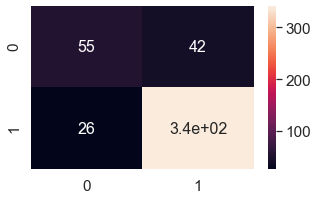

In [342]:
plt.rcParams.update({'figure.figsize': (5, 3)})
plt.rcParams.update({'font.size': 14})

sns.set(font_scale=1.4) # for label size
sns.heatmap(cf_all, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## Feature Importance

#### Scores dataframe

In [353]:
importance_sc = model_sc.feature_importances_

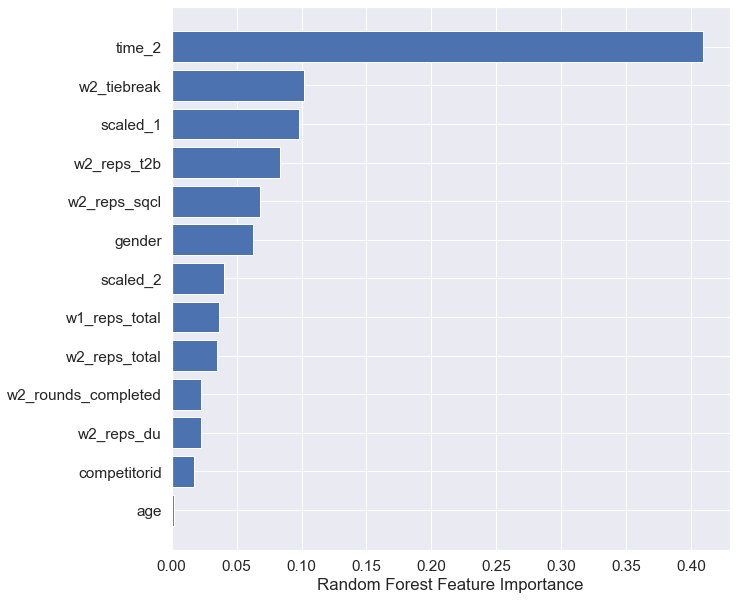

In [361]:
plt.rcParams.update({'figure.figsize': (10.0, 10.0)})
plt.rcParams.update({'font.size': 14})

sorted_idx = importance_sc.argsort()
plt.barh(X_sc.columns[sorted_idx], importance_sc[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

#### height&weight dataframe

#### Scores +hw dataframe

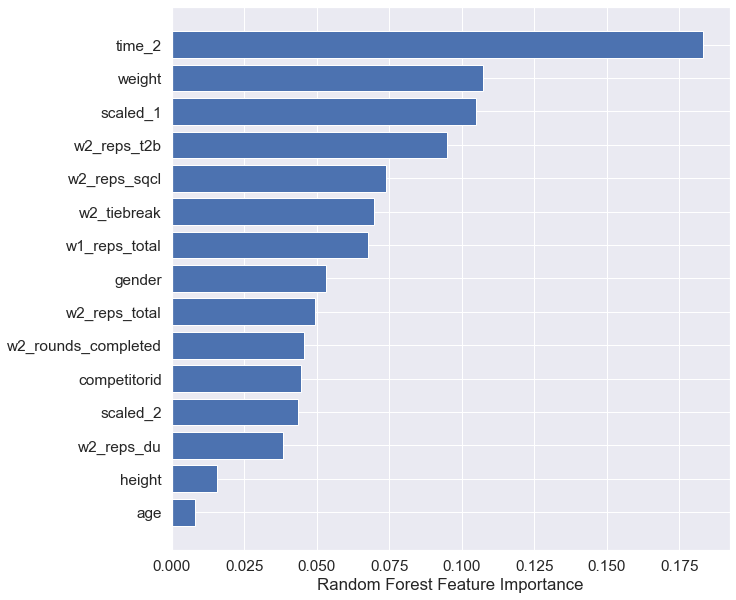

In [362]:
importance_sc_hw = model_sc_hw.feature_importances_

sorted_idx = importance_sc_hw.argsort()
plt.barh(X_sc_hw.columns[sorted_idx], importance_sc_hw[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

#### benchmark dataframe

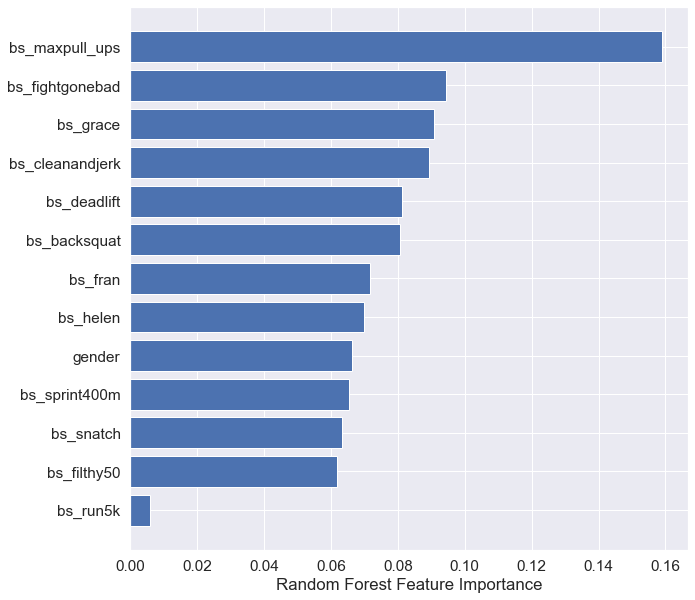

In [363]:
importance_bs = model_bs.feature_importances_

sorted_idx = importance_bs.argsort()
plt.barh(X_bs.columns[sorted_idx], importance_bs[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

#### all data

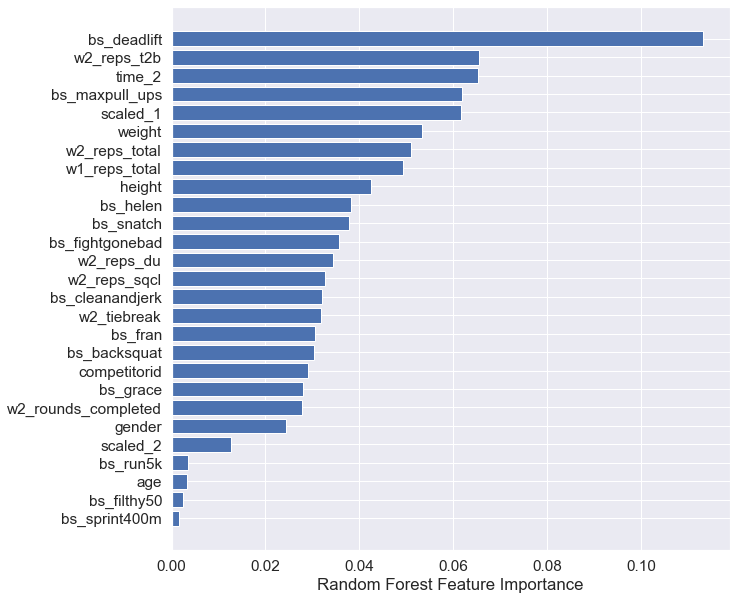

In [364]:
importance_all = model_all.feature_importances_

sorted_idx = importance_all.argsort()
plt.barh(X_all.columns[sorted_idx], importance_all[sorted_idx])
plt.xlabel("Random Forest Feature Importance");